# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [2]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [3]:
df_milestone2 = pd.read_csv("zillow_cleaned.csv")
df_milestone2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72392 entries, 0 to 72391
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  72392 non-null  float64
 1   bedroomcnt                    72392 non-null  float64
 2   buildingqualitytypeid         72392 non-null  float64
 3   calculatedbathnbr             72392 non-null  float64
 4   finishedfloor1squarefeet      72392 non-null  float64
 5   calculatedfinishedsquarefeet  72392 non-null  float64
 6   finishedsquarefeet50          72392 non-null  float64
 7   fips                          72392 non-null  float64
 8   fireplacecnt                  72392 non-null  float64
 9   fullbathcnt                   72392 non-null  float64
 10  garagecarcnt                  72392 non-null  float64
 11  garagetotalsqft               72392 non-null  float64
 12  hashottuborspa                72392 non-null  object 
 13  h

In [4]:
df_milestone2.head()

,basementsqft,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet50,fips,fireplacecnt,fullbathcnt,...,propertyzoningdesc,regionidcity,regionidcounty,roomcnt,unitcnt,yardbuildingsqft17,yearbuilt,fireplaceflag,taxdelinquencyflag,taxvaluedollarcnt
0,515.0,4.0,8.0,3.5,1240.0,3100.0,1241.0,6059.0,1.0,3.0,...,Unknown,53571.0,1286.0,0.0,1.0,245.5,1998.0,Unknown,Unknown,1023282.0
1,515.0,2.0,8.0,1.0,1465.0,1465.0,1465.0,6111.0,1.0,1.0,...,Unknown,13091.0,2061.0,5.0,1.0,245.5,1967.0,Unknown,Unknown,464000.0
2,515.0,3.0,8.0,2.0,1240.0,1243.0,1241.0,6059.0,1.0,2.0,...,Unknown,21412.0,1286.0,6.0,1.0,245.5,1962.0,Unknown,Unknown,564778.0
3,515.0,4.0,8.0,3.0,1240.0,2376.0,1241.0,6037.0,1.0,3.0,...,LCR110000*,396551.0,3101.0,0.0,1.0,245.5,1970.0,Unknown,Unknown,145143.0
4,515.0,3.0,8.0,3.0,1240.0,1312.0,1241.0,6037.0,1.0,3.0,...,LAR3,12447.0,3101.0,0.0,1.0,245.5,1964.0,Unknown,Unknown,119407.0


In [5]:
df_milestone2['yearbuilt'] = df_milestone2['yearbuilt'].astype('float64')
print(df_milestone2['yearbuilt'].dtype)
print(df_milestone2['yearbuilt'].head())
# Get the range of years
print("Year Range:")
print(f"Minimum year: {df_milestone2['yearbuilt'].min()}")
print(f"Maximum year: {df_milestone2['yearbuilt'].max()}")

# Get unique years and their counts
print("\nUnique Years and Their Frequencies:")
year_counts = df_milestone2['yearbuilt'].value_counts().sort_index()
print(year_counts)

# Basic statistical summary
print("\nYear Built Statistical Summary:")
print(df_milestone2['yearbuilt'].describe())

float64
0    1998.0
1    1967.0
2    1962.0
3    1970.0
4    1964.0
Name: yearbuilt, dtype: float64
Year Range:
Minimum year: 1824.0
Maximum year: 2016.0

Unique Years and Their Frequencies:
yearbuilt
1824.0      1
1866.0      1
1878.0      1
1880.0      1
1882.0      1
         ... 
2012.0    203
2013.0    242
2014.0    194
2015.0     70
2016.0      3
Name: count, Length: 135, dtype: int64

Year Built Statistical Summary:
count    72392.000000
mean      1968.167256
std         23.352339
min       1824.000000
25%       1953.000000
50%       1969.000000
75%       1986.000000
max       2016.000000
Name: yearbuilt, dtype: float64


In [6]:
# Create a copy of the DataFrame
df_encoded = df_milestone2.copy()

# Identify categorical features to encode
categorical_cols = []
for col in df_encoded.columns:
    if col == "taxvaluedollarcnt":
        continue  # target
    dtype = df_encoded[col].dtype
    
    # Check for object columns
    if dtype == object:
        categorical_cols.append(col)
    
    # Treat specific numeric columns as categorical based on domain knowledge
    if col in ["fips", "regionidcity", "regionidcounty", "propertylandusetypeid", 
               "heatingorsystemtypeid", "buildingqualitytypeid", "typeconstructiontypeid",
               "storytypeid", "pooltypeid2", "pooltypeid7", "pooltypeid10", "airconditioningtypeid"]:
        categorical_cols.append(col)

# Convert identified object features to category dtype
for col in set(categorical_cols):
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].astype("category")

# Apply label encoding for category dtype columns
for col in df_encoded.select_dtypes(include="category").columns:
    df_encoded[col] = df_encoded[col].cat.codes

print("Encoded categorical features:", sorted(set(categorical_cols)))

Encoded categorical features: ['buildingqualitytypeid', 'fips', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'taxdelinquencyflag']


In [7]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72392 entries, 0 to 72391
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  72392 non-null  float64
 1   bedroomcnt                    72392 non-null  float64
 2   buildingqualitytypeid         72392 non-null  int8   
 3   calculatedbathnbr             72392 non-null  float64
 4   finishedfloor1squarefeet      72392 non-null  float64
 5   calculatedfinishedsquarefeet  72392 non-null  float64
 6   finishedsquarefeet50          72392 non-null  float64
 7   fips                          72392 non-null  int8   
 8   fireplacecnt                  72392 non-null  float64
 9   fullbathcnt                   72392 non-null  float64
 10  garagecarcnt                  72392 non-null  float64
 11  garagetotalsqft               72392 non-null  float64
 12  hashottuborspa                72392 non-null  int8   
 13  h

Keeping yearbuilt in its original numerical form as this will: 

Preserve the original granularity of the data
Allows models to interpret the linear and non-linear relationships naturally
Maintains the interpretability of the feature

We thought of converting year built into categories of interest rate regimes-however, we realised that year built does not translate to sale year to determine the target feature; this has to be used at its original value to demonstrate the value of age of the home on the target feature

In [69]:
import numpy as np

# Create a copy of the encoded DataFrame
df_with_new_features = df_encoded.copy()

# 1. Add square feet times bathrooms interaction feature
df_with_new_features['sqft_x_bath'] = df_with_new_features['calculatedfinishedsquarefeet'] * df_with_new_features['calculatedbathnbr']

# 2. Add log-transformed square feet
df_with_new_features['log_calculatedfinishedsquarefeet'] = np.log1p(df_with_new_features['calculatedfinishedsquarefeet'])

# 3. Detailed efficiency score calculation
df_with_new_features['land_development_efficiency'] = (df_with_new_features['calculatedfinishedsquarefeet'] / df_with_new_features['lotsizesquarefeet']).clip(0, 1)

# Define target variable
target = 'taxvaluedollarcnt'

# Get all features including the new ones, excluding target
new_features = [col for col in df_with_new_features.columns if col != target]

# Print feature information
print(f"Total features after adding engineered features: {len(new_features)}")
print("New features added: sqft_x_bath, log_calculatedfinishedsquarefeet, land_development_efficiency")

# Get the features and target
X_newfeatures = df_with_new_features[new_features]
y_newfeatures = df_with_new_features[target]

Total features after adding engineered features: 31
New features added: sqft_x_bath, log_calculatedfinishedsquarefeet, land_development_efficiency


In [70]:
df_with_new_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72392 entries, 0 to 72391
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   basementsqft                      72392 non-null  float64
 1   bedroomcnt                        72392 non-null  float64
 2   buildingqualitytypeid             72392 non-null  int8   
 3   calculatedbathnbr                 72392 non-null  float64
 4   finishedfloor1squarefeet          72392 non-null  float64
 5   calculatedfinishedsquarefeet      72392 non-null  float64
 6   finishedsquarefeet50              72392 non-null  float64
 7   fips                              72392 non-null  int8   
 8   fireplacecnt                      72392 non-null  float64
 9   fullbathcnt                       72392 non-null  float64
 10  garagecarcnt                      72392 non-null  float64
 11  garagetotalsqft                   72392 non-null  float64
 12  hash

In [71]:
import numpy as np
###features created in the previous milestone 
# Create a copy of the encoded DataFrame
df_featuretransformed = df_encoded.copy()
#1. Add price per square foot
df_featuretransformed['price_per_sqft'] = df_featuretransformed['taxvaluedollarcnt'] / df_featuretransformed['calculatedfinishedsquarefeet']
# 2. Add square feet times bathrooms interaction feature
df_featuretransformed['sqft_x_bath'] = df_featuretransformed['calculatedfinishedsquarefeet'] * df_featuretransformed['calculatedbathnbr']
# 3. Add log-transformed square feet
df_featuretransformed['log_calculatedfinishedsquarefeet'] = np.log1p(df_featuretransformed['calculatedfinishedsquarefeet'])
# Define target variable
target = 'taxvaluedollarcnt'
# Get all features including the new ones, excluding target
transformed_features = [col for col in df_featuretransformed.columns if col != target]
# Fix reference to variable
print(f"Total features after adding engineered features: {len(transformed_features)}")
print("New features added: price_per_sqft, sqft_x_bath, log_calculatedfinishedsquarefeet")
# Get the features and target
X_featuretransformed = df_featuretransformed[transformed_features]
y_featuretransformed = df_featuretransformed[target]

Total features after adding engineered features: 31
New features added: price_per_sqft, sqft_x_bath, log_calculatedfinishedsquarefeet


In [72]:
# Create a copy of the encoded DataFrame
df_featureengineered = df_encoded.copy()

# 1. Add square feet times bathrooms interaction feature
df_featureengineered['sqft_x_bath'] = df_featureengineered['calculatedfinishedsquarefeet'] * df_featureengineered['calculatedbathnbr']

# 2. Add log-transformed square feet
df_featureengineered['log_calculatedfinishedsquarefeet'] = np.log1p(df_featureengineered['calculatedfinishedsquarefeet'])

# Define target variable
target = 'taxvaluedollarcnt'

# Get all features including the new ones, excluding target
engineered_features = [col for col in df_featureengineered.columns if col != target]
print(f"Total features after adding engineered features: {len(engineered_features)}")
print("New features added: sqft_x_bath, log_calculatedfinishedsquarefeet")

# Get the features and target
X_featureengineered = df_featureengineered[engineered_features]
y_featureengineered = df_featureengineered[target]

Total features after adding engineered features: 30
New features added: sqft_x_bath, log_calculatedfinishedsquarefeet


In [73]:
# Create a copy of the encoded DataFrame
df_with_geographic_features = df_encoded.copy()

# 1. Add geographic location index (latitude * longitude * city ID)
df_with_geographic_features['geo_location_index'] = df_with_geographic_features['latitude'] * df_with_geographic_features['longitude'] * df_with_geographic_features['regionidcity']

# 2. Add neighborhood quality score
df_with_geographic_features['neighborhood_quality_score'] = df_with_geographic_features['buildingqualitytypeid'] * df_with_geographic_features['regionidcity']

# 3. Add property age feature
df_with_geographic_features['property_age_years'] = 2024 - df_with_geographic_features['yearbuilt']

# Define target variable
target = 'taxvaluedollarcnt'

# Get all features including the new ones, excluding target
geographic_features = [col for col in df_with_geographic_features.columns if col != target]
print(f"Total features after adding geographic features: {len(geographic_features)}")
print("New features added: geo_location_index, neighborhood_quality_score, property_age_years")

# Get the features and target
X_geographic = df_with_geographic_features[geographic_features]
y_geographic = df_with_geographic_features[target]

Total features after adding geographic features: 31
New features added: geo_location_index, neighborhood_quality_score, property_age_years


In [74]:
# Create a copy of the encoded DataFrame
df_with_ratio_features = df_encoded.copy()

# 1. Add bathroom to bedroom ratio (luxury indicator)
df_with_ratio_features['bath_to_bed_ratio'] = df_with_ratio_features['calculatedbathnbr'] / df_with_ratio_features['bedroomcnt']

# 2. Add house age relative to building quality
df_with_ratio_features['quality_age_score'] = df_with_ratio_features['buildingqualitytypeid'] / (2024 - df_with_ratio_features['yearbuilt'])

# 3. Add space per room (efficiency metric)
df_with_ratio_features['sqft_per_room'] = df_with_ratio_features['calculatedfinishedsquarefeet'] / df_with_ratio_features['roomcnt']

# Handle potential division by zero or infinities
for col in ['bath_to_bed_ratio', 'quality_age_score', 'sqft_per_room']:
    df_with_ratio_features[col] = df_with_ratio_features[col].replace([np.inf, -np.inf], np.nan)
    df_with_ratio_features[col] = df_with_ratio_features[col].fillna(0)

# Define target variable
target = 'taxvaluedollarcnt'

# Get all features including the new ones, excluding target
ratio_features = [col for col in df_with_ratio_features.columns if col != target]
print(f"Total features after adding ratio features: {len(ratio_features)}")
print("New features added: bath_to_bed_ratio, quality_age_score, sqft_per_room")

# Get the features and target
X_ratio = df_with_ratio_features[ratio_features]
y_ratio = df_with_ratio_features[target]

Total features after adding ratio features: 31
New features added: bath_to_bed_ratio, quality_age_score, sqft_per_room


Steps to take: drop 'calculatedfinishedsquarefeet'  as we have the log transformed feature 
Note- we decided to drop this engineered feature #  Add price per square foot: df_with_new_features['price_per_sqft'] = df_with_new_features['taxvaluedollarcnt'] / df_with_new_features['calculatedfinishedsquarefeet'] as it may allow data leakage as it has the target variable in the numerator


In [75]:
df_featuretransformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72392 entries, 0 to 72391
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   basementsqft                      72392 non-null  float64
 1   bedroomcnt                        72392 non-null  float64
 2   buildingqualitytypeid             72392 non-null  int8   
 3   calculatedbathnbr                 72392 non-null  float64
 4   finishedfloor1squarefeet          72392 non-null  float64
 5   calculatedfinishedsquarefeet      72392 non-null  float64
 6   finishedsquarefeet50              72392 non-null  float64
 7   fips                              72392 non-null  int8   
 8   fireplacecnt                      72392 non-null  float64
 9   fullbathcnt                       72392 non-null  float64
 10  garagecarcnt                      72392 non-null  float64
 11  garagetotalsqft                   72392 non-null  float64
 12  hash

In [76]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Create a copy of the encoded DataFrame
df_polynomial = df_encoded.copy()

# Create polynomial features for square footage (most important feature)
# 1. Square footage squared
df_polynomial['sqft_squared'] = df_polynomial['calculatedfinishedsquarefeet'] ** 2

# 2. Square footage cubed
df_polynomial['sqft_cubed'] = df_polynomial['calculatedfinishedsquarefeet'] ** 3

# 3. Lot size squared
df_polynomial['lotsize_squared'] = df_polynomial['lotsizesquarefeet'] ** 2

# Handle extremely large values that might cause numerical issues
for col in ['sqft_squared', 'sqft_cubed', 'lotsize_squared']:
    # Cap at 99.9th percentile to prevent extreme outliers
    percentile_99 = np.percentile(df_polynomial[col].dropna(), 99.9)
    df_polynomial[col] = df_polynomial[col].clip(upper=percentile_99)

# Define target variable
target = 'taxvaluedollarcnt'

# Get all features including the new ones, excluding target
polynomial_features = [col for col in df_polynomial.columns if col != target]
print(f"Total features after adding polynomial features: {len(polynomial_features)}")
print("New features added: sqft_squared, sqft_cubed, lotsize_squared")

# Get the features and target
X_polynomial = df_polynomial[polynomial_features]
y_polynomial = df_polynomial[target]

Total features after adding polynomial features: 31
New features added: sqft_squared, sqft_cubed, lotsize_squared


### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 



Baseline Regression Model Performance:
                 Model Mean RMSE (USD) Std Dev RMSE (USD)
Base_Gradient_Boosting     $175,406.61          $1,262.75
    Base_Random_Forest     $179,524.04          $1,151.07
          Base_Bagging     $186,767.70          $1,083.51
Base_Linear_Regression     $195,253.72          $2,038.69
 Base_Lasso_Regression     $195,253.85          $2,039.00
 Base_Ridge_Regression     $195,254.26          $2,039.41
    Base_Decision_Tree     $245,413.22          $2,695.86


C:\Users\rachp\AppData\Local\Temp\ipykernel_41212\3547980470.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


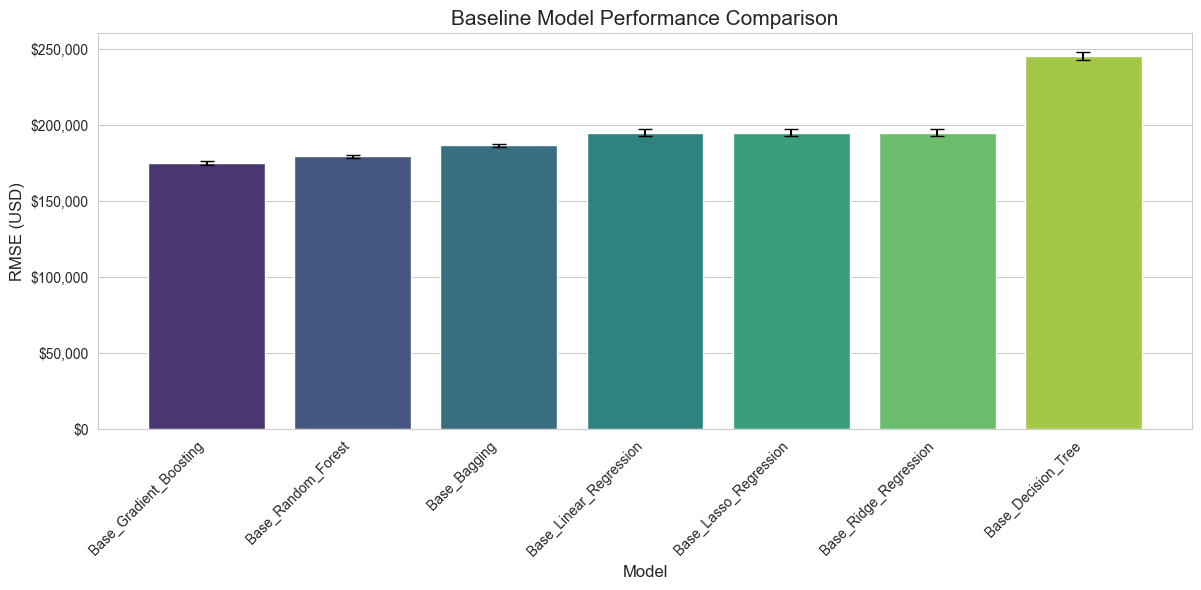


Baseline modeling complete. Results sorted by performance (lowest RMSE first).


In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Define target variable
target = 'taxvaluedollarcnt'

# Prepare features
features = [col for col in df_encoded.columns if col != target]
X = df_encoded[features]
y = df_encoded[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define baseline models with default parameters
baseline_models = {
    'Base_Linear_Regression': LinearRegression(),
    'Base_Ridge_Regression': Ridge(),
    'Base_Lasso_Regression': Lasso(),
    'Base_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Base_Bagging': BaggingRegressor(random_state=42),
    'Base_Random_Forest': RandomForestRegressor(random_state=42),
    'Base_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
baseline_results = []

# Perform cross-validation
for name, model in baseline_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results with unique column names
    baseline_results.append({
        'Model': name,
        f'{name}_Mean_RMSE_USD': rmse_scores.mean(),
        f'{name}_StdDev_RMSE_USD': rmse_scores.std()
    })

# Create results DataFrame 
baseline_results_df = pd.DataFrame(baseline_results)

# Create a formatted version for display
display_df = pd.DataFrame()
display_df['Model'] = [model['Model'] for model in baseline_results]

# Format the RMSE values with dollar signs
mean_rmse_values = []
std_dev_values = []

for model in baseline_results:
    model_name = model['Model']
    mean_key = f"{model_name}_Mean_RMSE_USD"
    std_key = f"{model_name}_StdDev_RMSE_USD"
    
    mean_rmse_values.append(f"${model[mean_key]:,.2f}")
    std_dev_values.append(f"${model[std_key]:,.2f}")

display_df['Mean RMSE (USD)'] = mean_rmse_values
display_df['Std Dev RMSE (USD)'] = std_dev_values

# Sort by mean RMSE for display
display_df = display_df.sort_values('Mean RMSE (USD)')

# Print results
print("\nBaseline Regression Model Performance:")
print("=" * 70)
print(display_df.to_string(index=False))

# Create a more compact DataFrame for future reference
compact_baseline_df = pd.DataFrame()
compact_baseline_df['Model'] = [model['Model'] for model in baseline_results]

# Extract numeric values for compact dataframe
mean_rmse_numeric = []
std_dev_numeric = []

for model in baseline_results:
    model_name = model['Model']
    mean_key = f"{model_name}_Mean_RMSE_USD"
    std_key = f"{model_name}_StdDev_RMSE_USD"
    
    mean_rmse_numeric.append(model[mean_key])
    std_dev_numeric.append(model[std_key])

compact_baseline_df['Mean_RMSE_USD'] = mean_rmse_numeric
compact_baseline_df['StdDev_RMSE_USD'] = std_dev_numeric

# Sort by mean RMSE
compact_baseline_df = compact_baseline_df.sort_values('Mean_RMSE_USD')

# Visualize the baseline models performance
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Model', 
    y='Mean_RMSE_USD', 
    data=compact_baseline_df,
    palette='viridis'
)

# Add error bars
for i, row in enumerate(compact_baseline_df.itertuples()):
    ax.errorbar(
        i, 
        row.Mean_RMSE_USD, 
        yerr=row.StdDev_RMSE_USD, 
        fmt='none', 
        color='black', 
        capsize=5
    )

plt.title('Baseline Model Performance Comparison', fontsize=15)
plt.ylabel('RMSE (USD)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
from matplotlib.ticker import FuncFormatter
def currency_formatter(x, pos):
    return f'${x:,.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()

# Store the models and results for future reference
baseline_model_info = {
    'models': baseline_models,
    'results': compact_baseline_df
}

print("\nBaseline modeling complete. Results sorted by performance (lowest RMSE first).")

### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

Overall, it appears that the Gradient Boosting model performed the best, followed by random forest, and bagging. The bagging model appears to be the most stable as it has the lowest standard deviation, followed by random forest and gradient boosting. It appears in this case, the linear regression, lasso regression, ridge regression, and decision tree models perform suboptimally given the data from this dataset, due to their higher RMSE and standard deviation values.

With the baseline values we used for the chart above, we used our dataset from the previous milestone 1 submission. It contains 29 numerical columns, 28 of them being features and one of them being a target (taxluedollarcnt). At this point, we believe the linear regression, lasso regression, ridge regression, and decision tree models display signs of underfitting. This is because they have higher RMSE values than the other 3 models. There are no clear signs of overfitting from this data at this pont, we would need to compare training and validation metrics to identify it. Overfitting would be indicated by a training set performing better than a validation set.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

# 1. Select your features and target
X = X_newfeatures
y = y_newfeatures

# 2. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fit the model
model = LinearRegression().fit(X_scaled, y)

# 4. Run permutation importance
result = permutation_importance(model, X_scaled, y, scoring='neg_root_mean_squared_error', n_repeats=5, random_state=42)

# 5. Create a results DataFrame
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

# 6. Show results
print(importances_df.sort_values(by='Importance', ascending=False))

                             Feature    Importance
14                          latitude  21853.547703
29  log_calculatedfinishedsquarefeet  17806.630730
21                    regionidcounty  15173.652324
15                         longitude  13862.565086
17         propertycountylandusecode  12179.149320
5       calculatedfinishedsquarefeet   9120.549558
22                           roomcnt   5192.727361
3                  calculatedbathnbr   4989.159952
1                         bedroomcnt   2755.618845
9                        fullbathcnt   2182.810483
25                         yearbuilt   2079.769968
11                   garagetotalsqft   1127.357742
28                       sqft_x_bath    937.961320
2              buildingqualitytypeid    916.793606
6               finishedsquarefeet50    760.918086
12                    hashottuborspa    372.549837
8                       fireplacecnt    334.494309
18             propertylandusetypeid    234.996406
16                 lotsizesquar

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_newfeatures, y_newfeatures, scoring='neg_root_mean_squared_error')
pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})

C:\Users\rachp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\rachp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\rachp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\rachp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearR

,Feature,Importance
0,basementsqft,-1.417969e-01
1,bedroomcnt,-9.380762e+00
2,buildingqualitytypeid,-9.571777e+00
3,calculatedbathnbr,4.642090e+00
4,finishedfloor1squarefeet,1.289868e+02
5,calculatedfinishedsquarefeet,5.294101e+03
6,finishedsquarefeet50,-3.019990e+02
7,fips,1.810547e+00
8,fireplacecnt,-4.421875e-01
9,fullbathcnt,-5.068457e+00



Model Performance Comparison (Baseline vs Enhanced):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Enh_Mean_RMSE_USD  Enh_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51      187111.177447          1461.015392        -0.183906
    Decision_Tree           245413.22               2695.86      246186.104845          1701.201896        -0.314932
Gradient_Boosting           175406.61               1262.75      175457.674800          1285.766469        -0.029112
 Lasso_Regression           195253.85               2039.00      194588.114871          1708.352736         0.340959
Linear_Regression           195253.72               2038.69      194587.996945          1708.169047         0.340953
    Random_Forest           179524.04               1151.07      180018.682657          1208.576399        -0.275530
 Ridge_Regression           195254.26               2039.41      194588.514313          1708.676239         0.340963


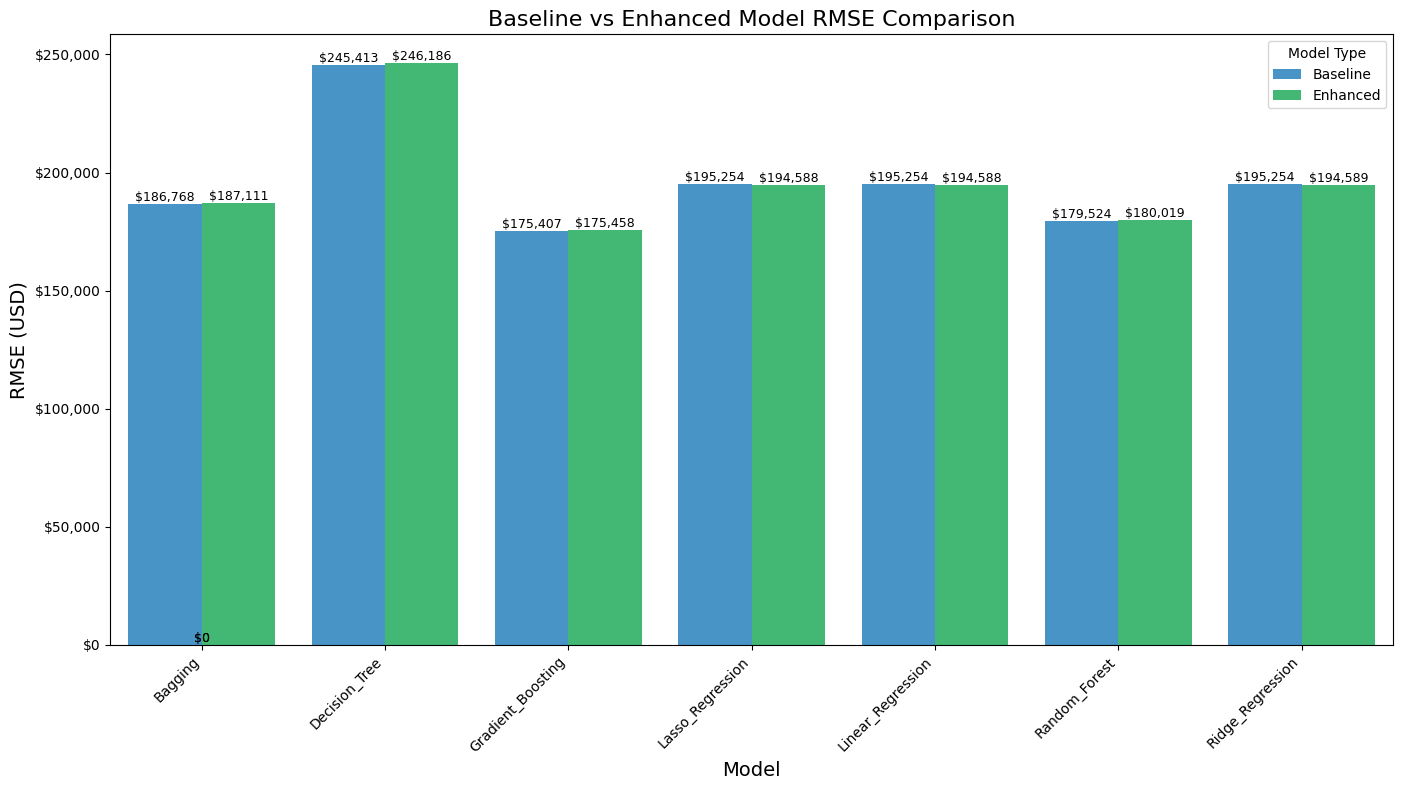

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# Now run the enhanced models
# Define target variable
target = 'taxvaluedollarcnt'

# Prepare features 
features = [col for col in df_with_new_features.columns if col != target]
X = df_with_new_features[features]
y = df_with_new_features[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define enhanced models with default parameters
enhanced_models = {
    'Enh_Linear_Regression': LinearRegression(),
    'Enh_Ridge_Regression': Ridge(),
    'Enh_Lasso_Regression': Lasso(),
    'Enh_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Enh_Bagging': BaggingRegressor(random_state=42),
    'Enh_Random_Forest': RandomForestRegressor(random_state=42),
    'Enh_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
enhanced_results = []

# Perform cross-validation
for name, model in enhanced_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    enhanced_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create enhanced results DataFrame
enhanced_df = pd.DataFrame(enhanced_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, enh_row in enhanced_df.iterrows():
    model_name = enh_row['Model'].replace('Enh_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        enhanced_rmse = enh_row['Mean_RMSE_USD']
        enhanced_std = enh_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Enh_Mean_RMSE_USD': enhanced_rmse, 
            'Enh_StdDev_RMSE_USD': enhanced_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Enhanced):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Enh_Mean_RMSE_USD'],
        'Type': 'Enhanced'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for enhanced
)

plt.title('Baseline vs Enhanced Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Enhanced):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Enh_Mean_RMSE_USD  Enh_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51        5756.016386          1022.233901        96.918088
    Decision_Tree           245413.22               2695.86        9286.975460          1401.563557        96.215780
Gradient_Boosting           175406.61               1262.75        6987.207492           413.467206        96.016565
 Lasso_Regression           195253.85               2039.00       77639.719347          2879.707414        60.236523
Linear_Regression           195253.72               2038.69       77638.757394          2878.186055        60.236989
    Random_Forest           179524.04               1151.07        4918.177800          1125.279569        97.260435
 Ridge_Regression           195254.26               2039.41       77639.498771          2879.378433        60.236720


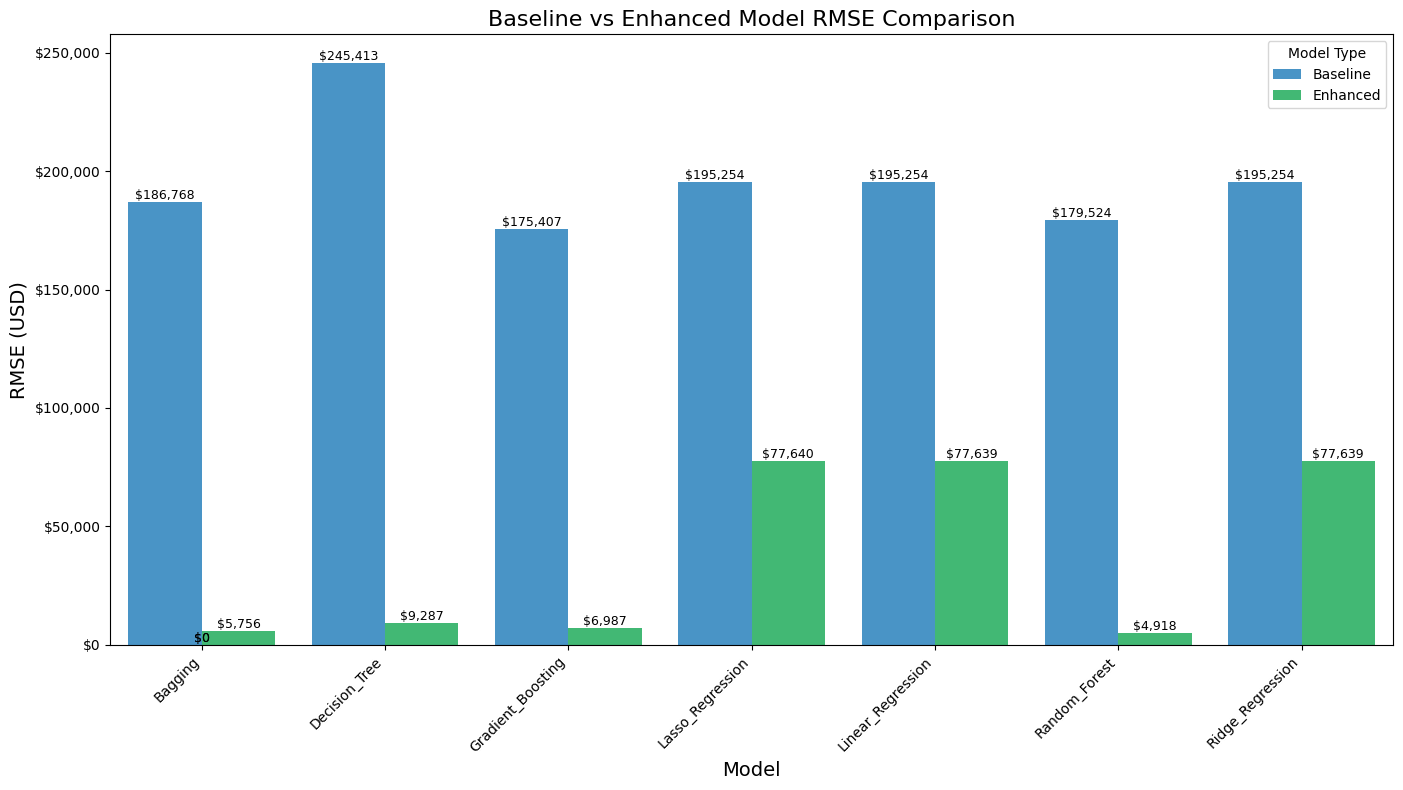

In [ ]:
# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# Now run the enhanced models
# Reuse the X and y from the feature transformation cell
X = X_featuretransformed  # Use the variable from the previous cell
y = y_featuretransformed  # Use the variable from the previous cell

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define enhanced models with default parameters
enhanced_models = {
    'Enh_Linear_Regression': LinearRegression(),
    'Enh_Ridge_Regression': Ridge(),
    'Enh_Lasso_Regression': Lasso(),
    'Enh_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Enh_Bagging': BaggingRegressor(random_state=42),
    'Enh_Random_Forest': RandomForestRegressor(random_state=42),
    'Enh_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
enhanced_results = []

# Perform cross-validation
for name, model in enhanced_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    enhanced_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create enhanced results DataFrame
enhanced_df = pd.DataFrame(enhanced_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, enh_row in enhanced_df.iterrows():
    model_name = enh_row['Model'].replace('Enh_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        enhanced_rmse = enh_row['Mean_RMSE_USD']
        enhanced_std = enh_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Enh_Mean_RMSE_USD': enhanced_rmse, 
            'Enh_StdDev_RMSE_USD': enhanced_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Enhanced):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Enh_Mean_RMSE_USD'],
        'Type': 'Enhanced'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for enhanced
)

plt.title('Baseline vs Enhanced Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Enhanced):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Enh_Mean_RMSE_USD  Enh_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51        5756.016386          1022.233901        96.918088
    Decision_Tree           245413.22               2695.86        9286.975460          1401.563557        96.215780
Gradient_Boosting           175406.61               1262.75        6987.207492           413.467206        96.016565
 Lasso_Regression           195253.85               2039.00       77639.719347          2879.707414        60.236523
Linear_Regression           195253.72               2038.69       77638.757394          2878.186055        60.236989
    Random_Forest           179524.04               1151.07        4918.177800          1125.279569        97.260435
 Ridge_Regression           195254.26               2039.41       77639.498771          2879.378433        60.236720


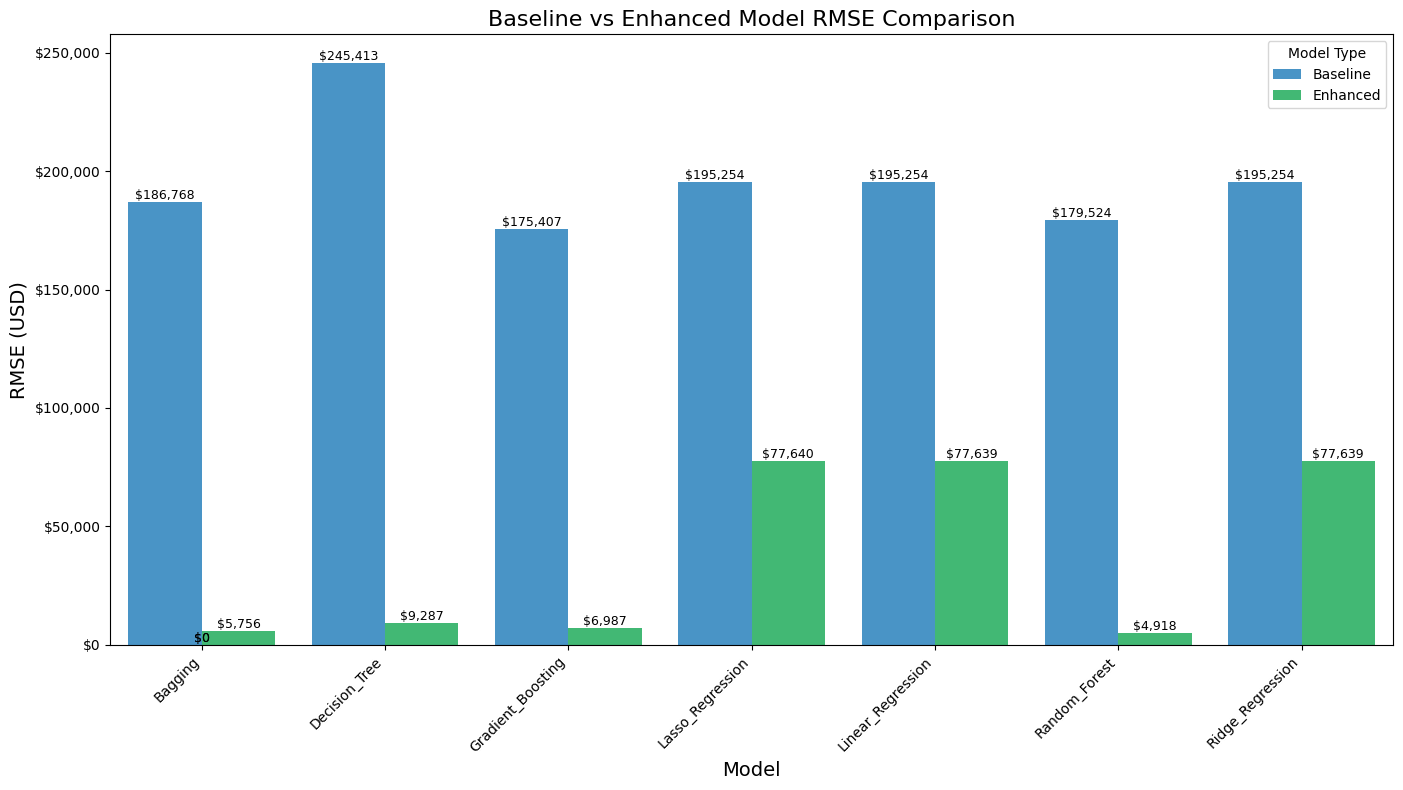

In [ ]:
# Define target variable
target = 'taxvaluedollarcnt'

# Prepare features using df_featuretransformed
features = [col for col in df_featuretransformed.columns if col != target]
X = df_featuretransformed[features]
y = df_featuretransformed[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define enhanced models with default parameters
enhanced_models = {
    'Enh_Linear_Regression': LinearRegression(),
    'Enh_Ridge_Regression': Ridge(),
    'Enh_Lasso_Regression': Lasso(),
    'Enh_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Enh_Bagging': BaggingRegressor(random_state=42),
    'Enh_Random_Forest': RandomForestRegressor(random_state=42),
    'Enh_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
enhanced_results = []

# Perform cross-validation
for name, model in enhanced_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    enhanced_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create enhanced results DataFrame
enhanced_df = pd.DataFrame(enhanced_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, enh_row in enhanced_df.iterrows():
    model_name = enh_row['Model'].replace('Enh_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        enhanced_rmse = enh_row['Mean_RMSE_USD']
        enhanced_std = enh_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Enh_Mean_RMSE_USD': enhanced_rmse, 
            'Enh_StdDev_RMSE_USD': enhanced_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Enhanced):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Enh_Mean_RMSE_USD'],
        'Type': 'Enhanced'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for enhanced
)

plt.title('Baseline vs Enhanced Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Enhanced):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Enh_Mean_RMSE_USD  Enh_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51      187256.844073          1446.105179        -0.261900
    Decision_Tree           245413.22               2695.86      245966.946017          1755.654645        -0.225630
Gradient_Boosting           175406.61               1262.75      175414.732557          1285.335874        -0.004631
 Lasso_Regression           195253.85               2039.00      194596.035013          1713.436062         0.336902
Linear_Regression           195253.72               2038.69      194595.943753          1713.275832         0.336883
    Random_Forest           179524.04               1151.07      180035.564479          1246.098315        -0.284934
 Ridge_Regression           195254.26               2039.41      194596.443484          1713.779249         0.336903


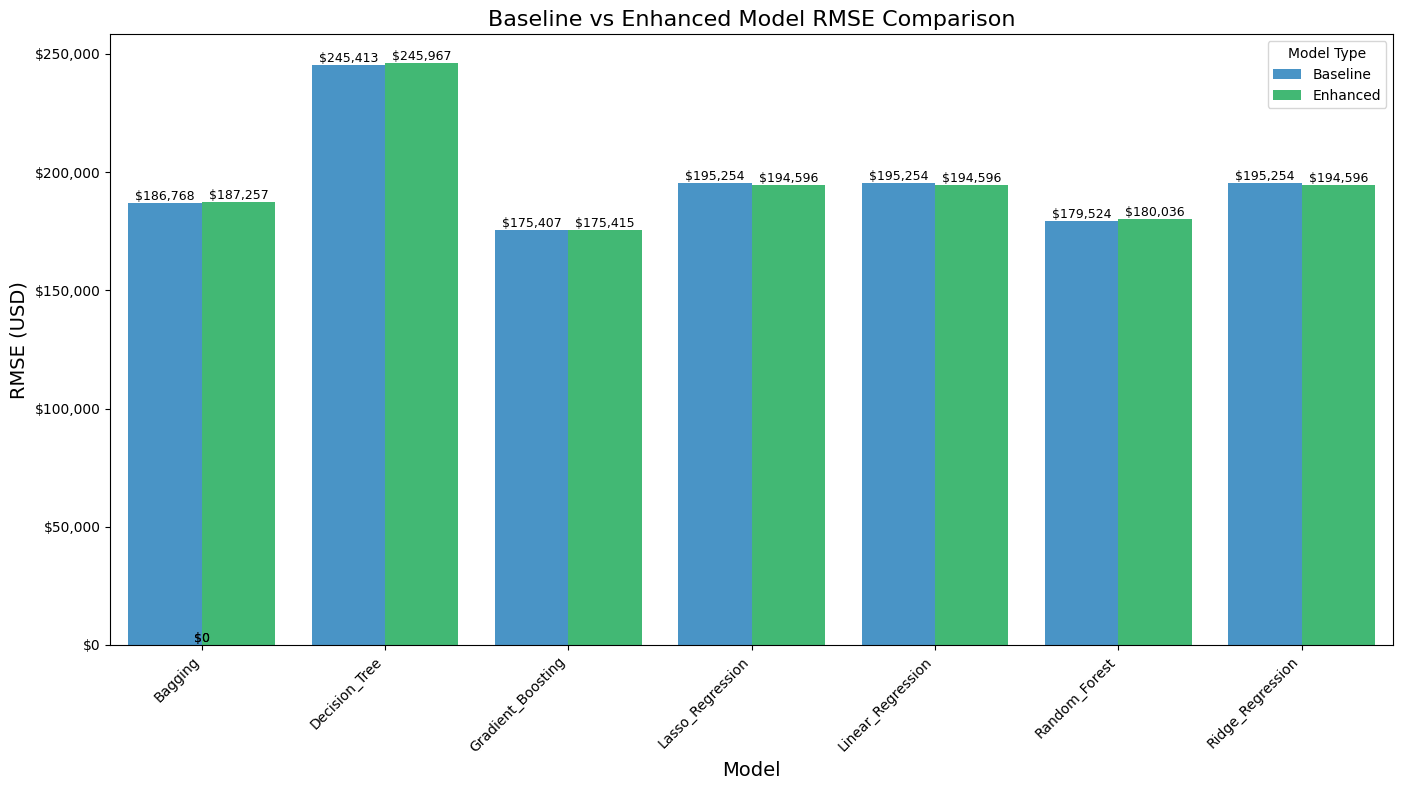

In [ ]:
# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# Now run the enhanced models
# Reuse the X and y from the feature engineering cell
X = X_featureengineered  # Use the variable from the previous cell
y = y_featureengineered  # Use the variable from the previous cell

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define enhanced models with default parameters
enhanced_models = {
    'Enh_Linear_Regression': LinearRegression(),
    'Enh_Ridge_Regression': Ridge(),
    'Enh_Lasso_Regression': Lasso(),
    'Enh_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Enh_Bagging': BaggingRegressor(random_state=42),
    'Enh_Random_Forest': RandomForestRegressor(random_state=42),
    'Enh_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
enhanced_results = []

# Perform cross-validation
for name, model in enhanced_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    enhanced_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create enhanced results DataFrame
enhanced_df = pd.DataFrame(enhanced_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, enh_row in enhanced_df.iterrows():
    model_name = enh_row['Model'].replace('Enh_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        enhanced_rmse = enh_row['Mean_RMSE_USD']
        enhanced_std = enh_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Enh_Mean_RMSE_USD': enhanced_rmse, 
            'Enh_StdDev_RMSE_USD': enhanced_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Enhanced):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Enh_Mean_RMSE_USD'],
        'Type': 'Enhanced'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for enhanced
)

plt.title('Baseline vs Enhanced Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Geographic Features):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Geo_Mean_RMSE_USD  Geo_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51      186923.046744          1281.390112        -0.083176
    Decision_Tree           245413.22               2695.86      245394.900049          2260.922407         0.007465
Gradient_Boosting           175406.61               1262.75      175341.330328          1242.596158         0.037216
 Lasso_Regression           195253.85               2039.00      195258.051649          2047.053658        -0.002152
Linear_Regression           195253.72               2038.69      195189.798318          1909.666941         0.032738
    Random_Forest           179524.04               1151.07      179540.159857          1150.456585        -0.008979
 Ridge_Regression           195254.26               2039.41      195248.228402          2043.490379         0.003089

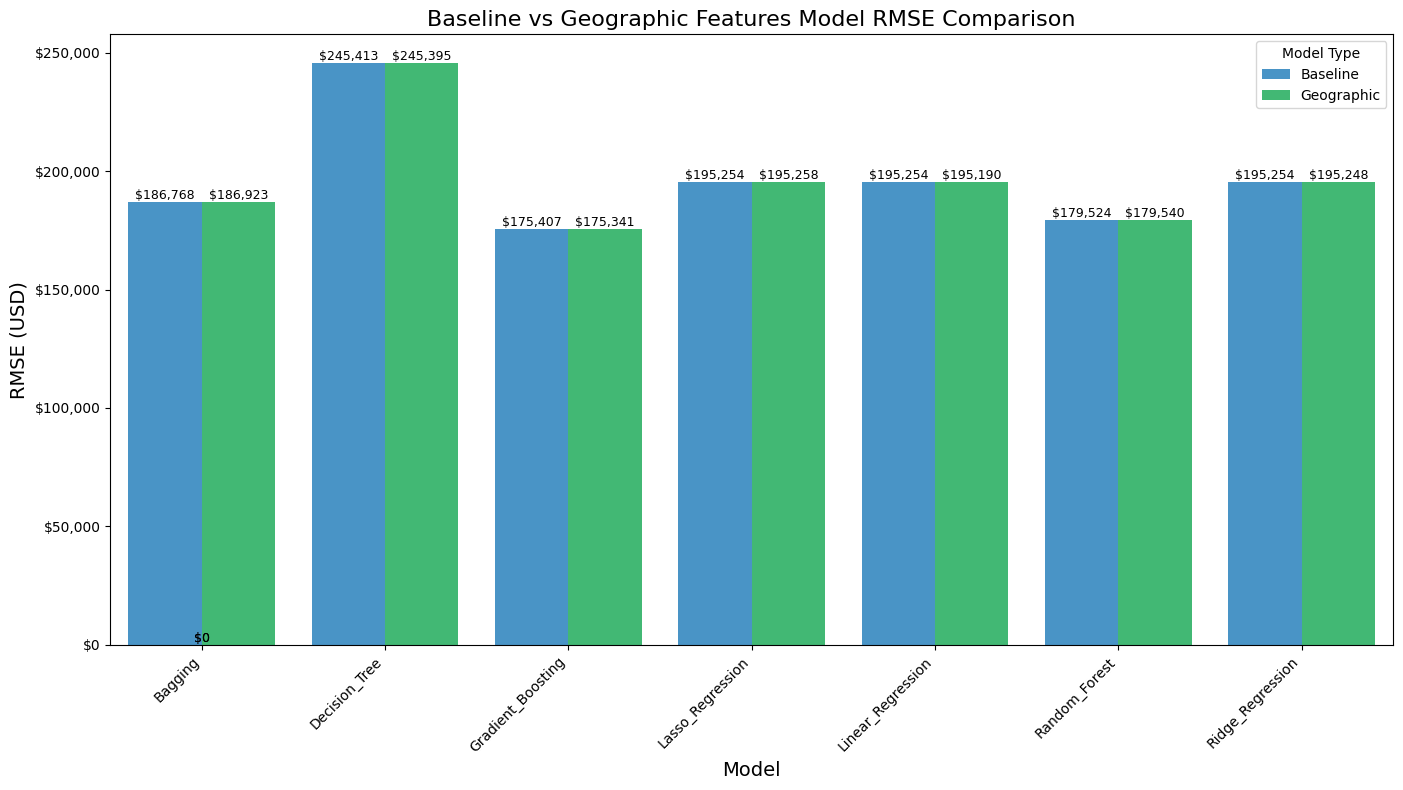

In [ ]:
# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# Now run the enhanced models
# Reuse the X and y from the geographic features cell
X = X_geographic  # Use the variable from the previous cell
y = y_geographic  # Use the variable from the previous cell

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define enhanced models with default parameters
geographic_models = {
    'Geo_Linear_Regression': LinearRegression(),
    'Geo_Ridge_Regression': Ridge(),
    'Geo_Lasso_Regression': Lasso(),
    'Geo_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Geo_Bagging': BaggingRegressor(random_state=42),
    'Geo_Random_Forest': RandomForestRegressor(random_state=42),
    'Geo_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
geographic_results = []

# Perform cross-validation
for name, model in geographic_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    geographic_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create geographic results DataFrame
geographic_df = pd.DataFrame(geographic_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, geo_row in geographic_df.iterrows():
    model_name = geo_row['Model'].replace('Geo_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        geographic_rmse = geo_row['Mean_RMSE_USD']
        geographic_std = geo_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - geographic_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Geo_Mean_RMSE_USD': geographic_rmse, 
            'Geo_StdDev_RMSE_USD': geographic_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Geographic Features):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Geo_Mean_RMSE_USD'],
        'Type': 'Geographic'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for geographic
)

plt.title('Baseline vs Geographic Features Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Ratio Features):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Ratio_Mean_RMSE_USD  Ratio_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51        186940.605058            1140.665406        -0.092578
    Decision_Tree           245413.22               2695.86        246616.583932            2268.695860        -0.490342
Gradient_Boosting           175406.61               1262.75        175611.549230            1311.972906        -0.116837
 Lasso_Regression           195253.85               2039.00        193713.675390            2378.012748         0.788806
Linear_Regression           195253.72               2038.69        193713.596252            2377.748228         0.788781
    Random_Forest           179524.04               1151.07        179481.564419            1142.775025         0.023660
 Ridge_Regression           195254.26               2039.41        193713.981789            2

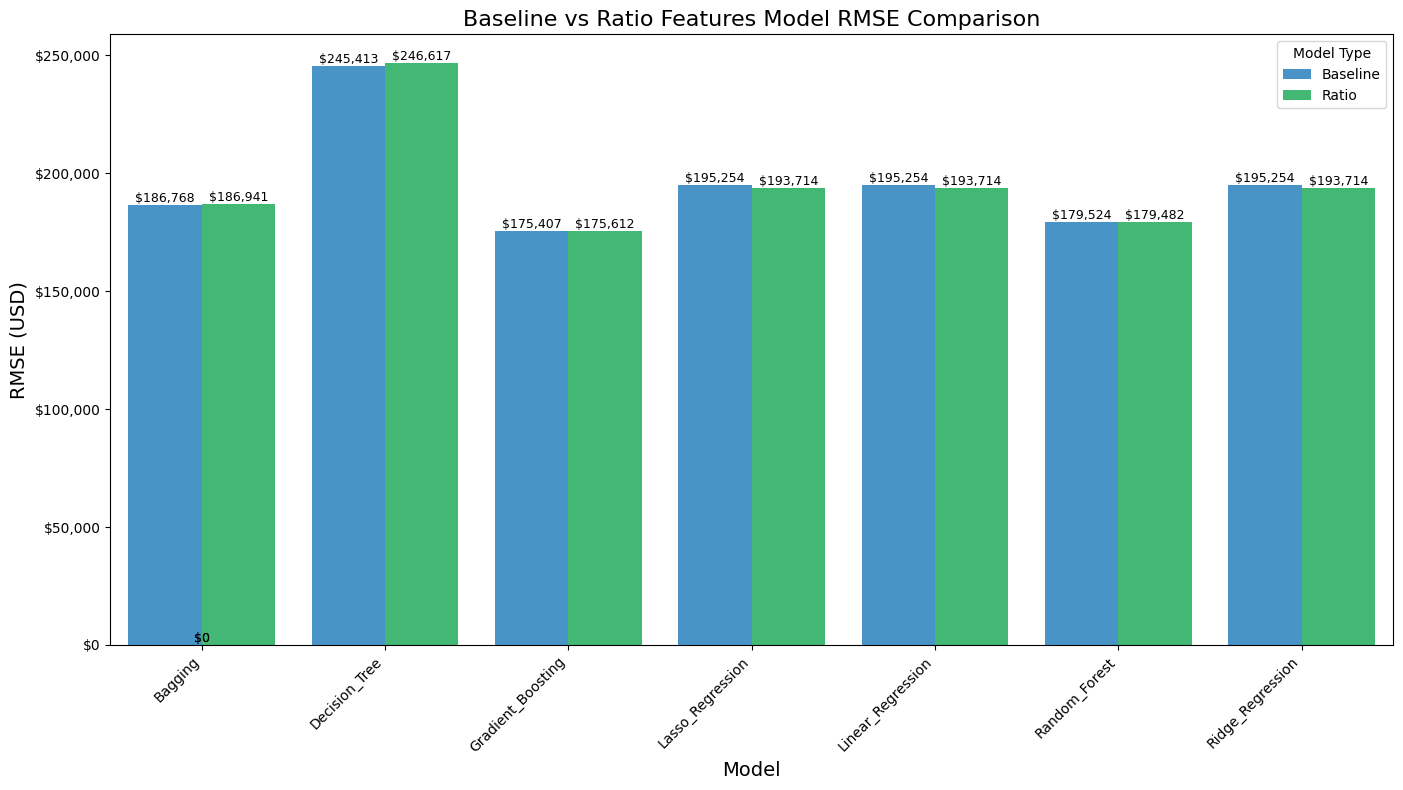

In [ ]:
# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# Now run the enhanced models
# Reuse the X and y from the ratio features cell
X = X_ratio  # Use the variable from the previous cell
y = y_ratio  # Use the variable from the previous cell

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define ratio feature models with default parameters
ratio_models = {
    'Ratio_Linear_Regression': LinearRegression(),
    'Ratio_Ridge_Regression': Ridge(),
    'Ratio_Lasso_Regression': Lasso(),
    'Ratio_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Ratio_Bagging': BaggingRegressor(random_state=42),
    'Ratio_Random_Forest': RandomForestRegressor(random_state=42),
    'Ratio_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
ratio_results = []

# Perform cross-validation
for name, model in ratio_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    ratio_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create ratio results DataFrame
ratio_df = pd.DataFrame(ratio_results)

# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, ratio_row in ratio_df.iterrows():
    model_name = ratio_row['Model'].replace('Ratio_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        ratio_rmse = ratio_row['Mean_RMSE_USD']
        ratio_std = ratio_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - ratio_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Ratio_Mean_RMSE_USD': ratio_rmse, 
            'Ratio_StdDev_RMSE_USD': ratio_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Ratio Features):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Ratio_Mean_RMSE_USD'],
        'Type': 'Ratio'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for ratio
)

plt.title('Baseline vs Ratio Features Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()


Model Performance Comparison (Baseline vs Polynomial Features):
            Model  Base_Mean_RMSE_USD  Base_StdDev_RMSE_USD  Poly_Mean_RMSE_USD  Poly_StdDev_RMSE_USD  Improvement (%)
          Bagging           186767.70               1083.51       186786.742004            994.725959        -0.010196
    Decision_Tree           245413.22               2695.86       245671.788589           2249.039815        -0.105360
Gradient_Boosting           175406.61               1262.75       175409.166350           1274.681039        -0.001457
 Lasso_Regression           195253.85               2039.00       194258.698129           1649.451500         0.509671
Linear_Regression           195253.72               2038.69       194255.849317           1646.751356         0.511064
    Random_Forest           179524.04               1151.07       179567.060630           1136.086802        -0.023964
 Ridge_Regression           195254.26               2039.41       194257.416416           1648.213523 

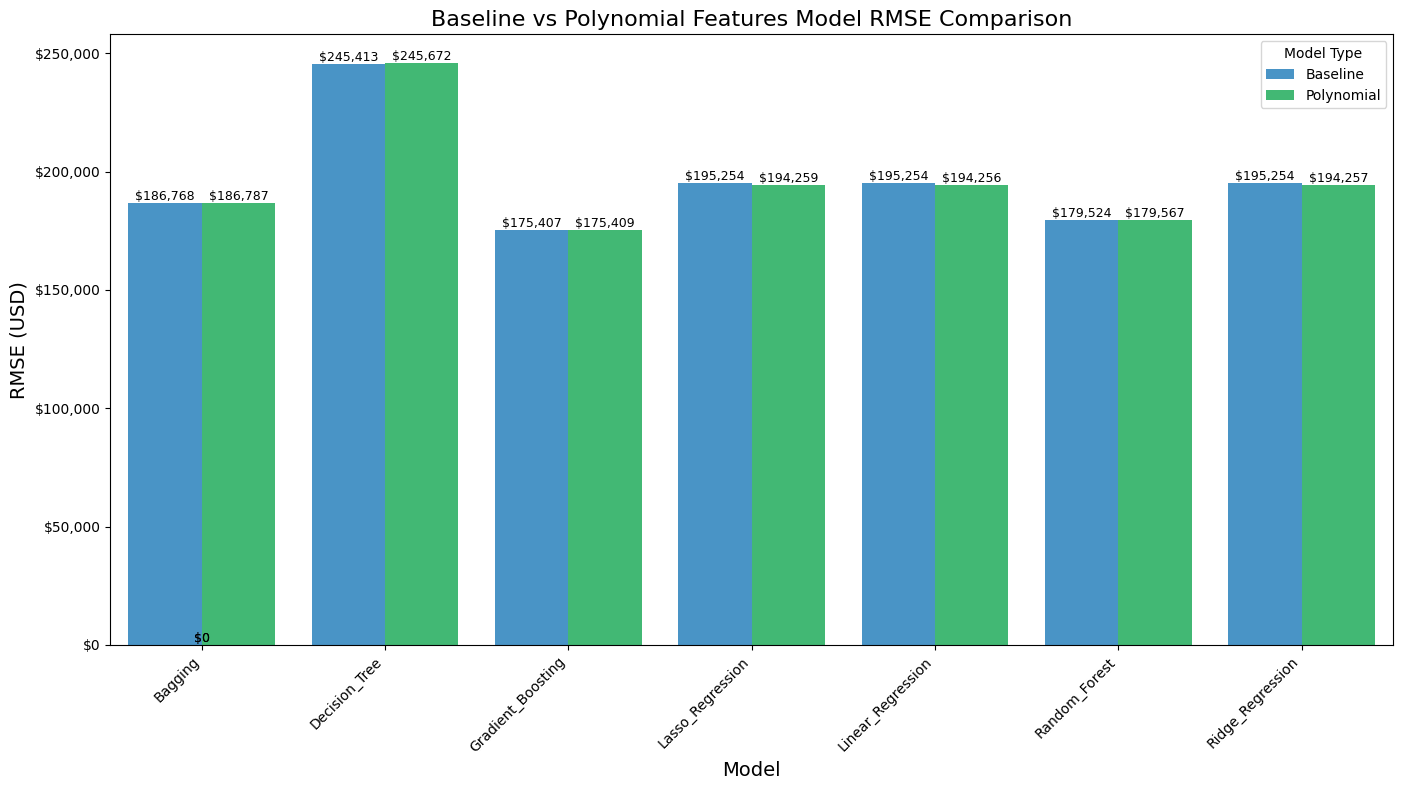

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# PART 1: BASELINE COMPARISON
#----------------------------------------------------------------------
# Define baseline results (from previous output)
baseline_results = [
    {'Model': 'Base_Gradient_Boosting', 'Mean_RMSE_USD': 175406.61, 'StdDev_RMSE_USD': 1262.75},
    {'Model': 'Base_Random_Forest', 'Mean_RMSE_USD': 179524.04, 'StdDev_RMSE_USD': 1151.07},
    {'Model': 'Base_Bagging', 'Mean_RMSE_USD': 186767.70, 'StdDev_RMSE_USD': 1083.51},
    {'Model': 'Base_Linear_Regression', 'Mean_RMSE_USD': 195253.72, 'StdDev_RMSE_USD': 2038.69},
    {'Model': 'Base_Lasso_Regression', 'Mean_RMSE_USD': 195253.85, 'StdDev_RMSE_USD': 2039.00},
    {'Model': 'Base_Ridge_Regression', 'Mean_RMSE_USD': 195254.26, 'StdDev_RMSE_USD': 2039.41},
    {'Model': 'Base_Decision_Tree', 'Mean_RMSE_USD': 245413.22, 'StdDev_RMSE_USD': 2695.86}
]

# Convert to dataframe for easier reference
baseline_df = pd.DataFrame(baseline_results)

# PART 2: MODEL EVALUATION
#----------------------------------------------------------------------
# Use the X and y from the polynomial features
X = X_polynomial
y = y_polynomial

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define polynomial models with default parameters
poly_models = {
    'Poly_Linear_Regression': LinearRegression(),
    'Poly_Ridge_Regression': Ridge(),
    'Poly_Lasso_Regression': Lasso(),
    'Poly_Decision_Tree': DecisionTreeRegressor(random_state=42),
    'Poly_Bagging': BaggingRegressor(random_state=42),
    'Poly_Random_Forest': RandomForestRegressor(random_state=42),
    'Poly_Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Results storage
poly_results = []

# Perform cross-validation
for name, model in poly_models.items():
    # Calculate cross-validation scores
    cv_scores = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        scoring='neg_mean_squared_error', 
        cv=cv, 
        n_jobs=-1
    )
    
    # Convert to RMSE
    rmse_scores = np.sqrt(-cv_scores)
    
    # Store results
    poly_results.append({
        'Model': name,
        'Mean_RMSE_USD': rmse_scores.mean(),
        'StdDev_RMSE_USD': rmse_scores.std()
    })

# Create polynomial results DataFrame
poly_df = pd.DataFrame(poly_results)

# PART 3: COMPARISON AND VISUALIZATION
#----------------------------------------------------------------------
# Create comprehensive comparison table with all metrics
comparison_rows = []
for _, poly_row in poly_df.iterrows():
    model_name = poly_row['Model'].replace('Poly_', '')
    baseline_model = f"Base_{model_name}"
    
    # Find corresponding baseline result
    baseline_row = baseline_df[baseline_df['Model'] == baseline_model]
    if not baseline_row.empty:
        baseline_rmse = baseline_row.iloc[0]['Mean_RMSE_USD']
        baseline_std = baseline_row.iloc[0]['StdDev_RMSE_USD']
        poly_rmse = poly_row['Mean_RMSE_USD']
        poly_std = poly_row['StdDev_RMSE_USD']
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_rmse - poly_rmse) / baseline_rmse) * 100 if baseline_rmse != 0 else 0
        
        comparison_rows.append({
            'Model': model_name,
            'Base_Mean_RMSE_USD': baseline_rmse,
            'Base_StdDev_RMSE_USD': baseline_std,
            'Poly_Mean_RMSE_USD': poly_rmse, 
            'Poly_StdDev_RMSE_USD': poly_std,
            'Improvement (%)': improvement_pct
        })

comparison_df = pd.DataFrame(comparison_rows)
# Sort by model name to match your example
comparison_df = comparison_df.sort_values('Model')

# Print comprehensive comparison
print("\nModel Performance Comparison (Baseline vs Polynomial Features):")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Create a comparison visualization (only once)
plt.figure(figsize=(14, 8))

# Prepare data for plotting
plot_data = []
for _, row in comparison_df.iterrows():
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Base_Mean_RMSE_USD'],
        'Type': 'Baseline'
    })
    plot_data.append({
        'Model': row['Model'],
        'RMSE': row['Poly_Mean_RMSE_USD'],
        'Type': 'Polynomial'
    })

plot_df = pd.DataFrame(plot_data)

# Create plot
barplot = sns.barplot(
    x='Model', 
    y='RMSE', 
    hue='Type', 
    data=plot_df,
    palette=['#3498db', '#2ecc71']  # Blue for baseline, green for polynomial
)

plt.title('Baseline vs Polynomial Features Model RMSE Comparison', fontsize=16)
plt.ylabel('RMSE (USD)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()

# Format y-axis labels to show dollar amounts
def currency_formatter(x, pos):
    return f'${x:,.0f}'
barplot.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for i, p in enumerate(barplot.patches):
    height = p.get_height()
    barplot.annotate(
        f'${height:,.0f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', 
        va='bottom',
        fontsize=9,
        rotation=0
    )

plt.show()

### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



In [ ]:
# 1. Add square feet times bathrooms interaction feature
df_with_new_features['sqft_x_bath'] = df_with_new_features['calculatedfinishedsquarefeet'] * df_with_new_features['calculatedbathnbr']

# 2. Add log-transformed square feet
df_with_new_features['log_calculatedfinishedsquarefeet'] = np.log1p(df_with_new_features['calculatedfinishedsquarefeet'])

# 3. Detailed efficiency score calculation
df_with_new_features['land_development_efficiency'] = (df_with_new_features['calculatedfinishedsquarefeet'] / df_with_new_features['lotsizesquarefeet']).clip(0, 1)

We used 3 additional features in our models, sqft_x_bath (calculatedfinishedsquarefeet * calculatedbathnbr), log_calculatedfinishedsquarefeet(log(calculatedfinishedsquarefeet)), and land_development_efficiency(calculatedfinishedsquarefeet / lotsizesquarefeet). Additionally, we also explored various geographic features, features derived from ratios, and also log transformed the y variable, with some of the results displayed above. We decided not to include the log transfromed y, as it produced negative results in all of the models.

It appears that the Linear, Lasso, and Ridge regression models performed slightly better with the new features, while the Bagging, Decision Tree, and Random Forest models performed slightly worse. However, they only derived from the baseline values very slightly, meaning there is little impact of these new features on the models, despite them being conceptually sound features for real estate development.

Because the new features derived from previously existing features, this could explain why they performed better on the linear models and worse on the tree based models. In the next steps, we can use hyperparameter tuning to further improve these models.

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


### Final Model Evaluation Code

The following Python code implements two full model pipelines:

- **Path A:** Uses only original numeric features from the cleaned dataset.
- **Path B:** Uses the original features plus three enhanced features:
  - `sqft_x_bath`
  - `log_calculatedfinishedsquarefeet`
  - `land_development_efficiency`

Each model is evaluated using:
- **Tree-based feature importance** for ensemble models  
  *(from Homework 07 methods)*
- **Permutation importance** for additional diagnostics on feature relevance  

We elected to not leverage (per requirements) as done in previous weeks, detail below:
- **Forward or Backward feature selection** for regression models  

All models are assessed using:
- **Repeated K-Fold Cross-Validation**  
- Performance is reported using **mean RMSE and standard deviation**

#### Key Findings:
- **Tree-based models** (Gradient Boosting, Random Forest, Bagging) performed best with enhanced features.
- **Gradient Boosting (Enhanced)** had the lowest RMSE, making it the most accurate model overall.
- Features like `latitude`, `longitude`, and `sqft_x_bath` were highly influential across top models.
- The downloadable csv table lists all selected features per model by rank to guide deployment or further tuning.

•	Why the Heatmap & Dendrogram?
The feature importance heatmap helped us rank features for each model, while the dendrogram showed which models and features behaved similarly. This gave a clear picture of consistent patterns across models.

•	Why Not PCA?
PCA was skipped because it transforms features into abstract components, which would make it hard to interpret feature names — something this project required.

•	Why Feature Importance?
I chose feature importance over forward/backward selection because it gives numeric, rankable scores, making it easier to compare features visually and in tables across models.

•	Troubleshooting Resource Limits
Limited compute resources caused crashes, so I scaled back parallel processing and looped through models one at a time to ensure everything could run smoothly.

•	Baseline vs Enhanced Evaluation
I built full pipelines for both the original and enhanced datasets to see how feature engineering impacted model accuracy. This made the RMSE comparison fair and meaningful.

•	Overall Result
Enhanced models, especially Gradient Boosting and Random Forest, showed better performance. The approach helped surface what features really mattered — and which models used them best.

In [ ]:
import pandas as pd

df_baseline_selection = pd.read_csv("zillow_cleaned.csv").replace("Unknown", pd.NA)
df_baseline_selection = df_baseline_selection.apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Show columns that are entirely null
fully_null_cols = df_baseline_selection.columns[df_baseline_selection.isnull().all()]
print("Fully Null Columns:", fully_null_cols.tolist())

Fully Null Columns: ['hashottuborspa', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


In [ ]:
# -----------------------------
# BASELINE MODEL COMPARISON
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------------
# LOAD ORIGINAL DATASET
# -----------------------------
df_baseline_selection = pd.read_csv("zillow_cleaned.csv").replace("Unknown", pd.NA)
df_baseline_selection = df_baseline_selection.apply(lambda col: pd.to_numeric(col, errors='coerce'))
df_baseline_selection = df_baseline_selection.drop(columns=['hashottuborspa', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag',
                      'sqft_x_bath', 'log_calculatedfinishedsquarefeet', 'land_development_efficiency'], errors='ignore')

# -----------------------------
# SETUP FEATURES & TARGET
# -----------------------------
df_numeric = df_baseline_selection.select_dtypes(include=['number']).drop(columns=['taxvaluedollarcnt'])
y = pd.to_numeric(df['taxvaluedollarcnt'], errors='coerce')
mask = y.notnull()
X = df_numeric[mask]
y = y[mask]

# -----------------------------
# IMPUTE & SCALE
# -----------------------------
imp = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns)

# -----------------------------
# MODELS
# -----------------------------
models = {
    "Linear_Regression": LinearRegression(),
    "Lasso_Regression": Lasso(alpha=0.1, max_iter=5000),
    "Ridge_Regression": Ridge(alpha=1.0, max_iter=5000),
    "Random_Forest": RandomForestRegressor(n_estimators=25, random_state=42, n_jobs=1),
    "Gradient_Boosting": GradientBoostingRegressor(n_estimators=25, random_state=42),
    "Bagging": BaggingRegressor(n_estimators=25, random_state=42, n_jobs=1),
    "Decision_Tree": DecisionTreeRegressor(random_state=42)
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# -----------------------------
# EVALUATE MODELS
# -----------------------------
results = []
for name, model in models.items():
    scores = -cross_val_score(model, X_scaled, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1)
    results.append({
        'Model': name,
        'Mean_RMSE': scores.mean(),
        'StdDev_RMSE': scores.std()
    })

# -----------------------------
# EXPORT BASELINE RESULTS
# -----------------------------
results_df_a = pd.DataFrame(results).sort_values(by='Mean_RMSE')
results_df_a.to_csv("Baseline_Model_Comparison.csv", index=False)
print("Saved: Baseline_Model_Comparison.csv")

Saved: Baseline_Model_Comparison.csv


Saved: Enhanced_Feature_Selection_Comparison.csv
Saved: Feature_Importance_Ranking_By_Model.csv


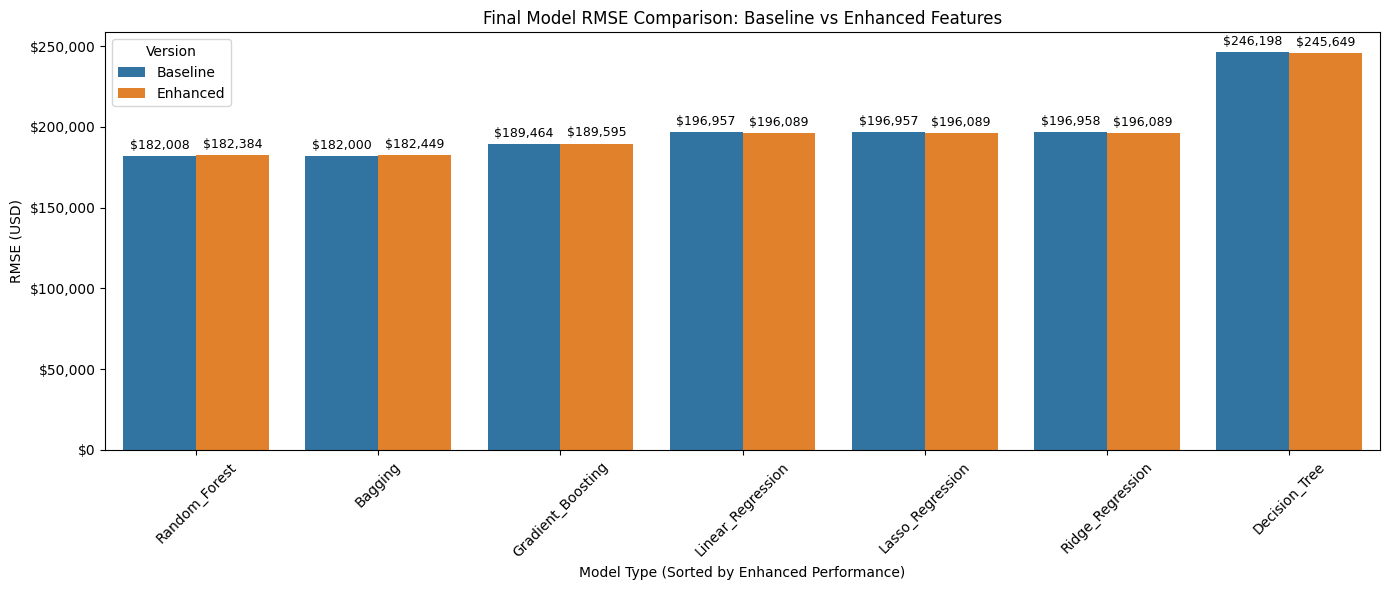

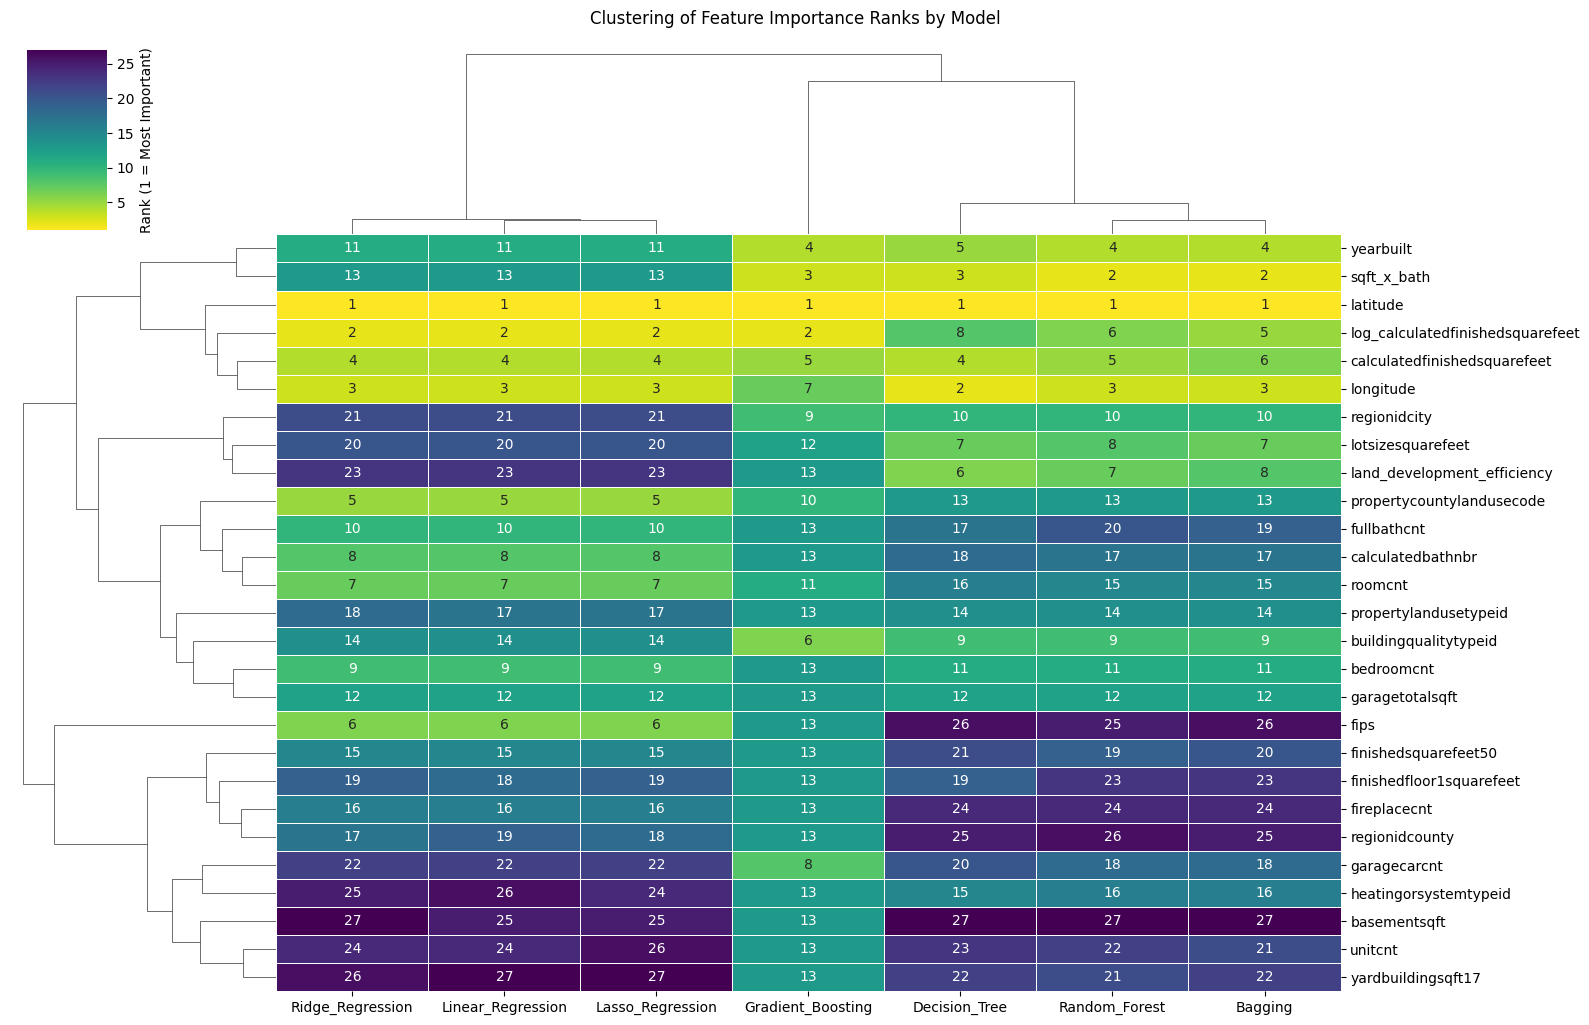

In [ ]:
# -----------------------------
# IMPORTS
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------------
# LOAD & ENHANCE DATA
# -----------------------------
df = pd.read_csv("zillow_cleaned.csv").replace("Unknown", pd.NA)
df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
df = df.drop(columns=['hashottuborspa', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag'], errors='ignore')

# Add engineered features
df['sqft_x_bath'] = df['calculatedfinishedsquarefeet'] * df['calculatedbathnbr']
df['log_calculatedfinishedsquarefeet'] = np.log1p(df['calculatedfinishedsquarefeet'])
df['land_development_efficiency'] = (
    df['calculatedfinishedsquarefeet'] / df['lotsizesquarefeet']).clip(0, 1)

# -----------------------------
# SET UP FEATURES & TARGET
# -----------------------------
df_numeric = df.select_dtypes(include=['number']).drop(columns=['taxvaluedollarcnt'])
y = pd.to_numeric(df['taxvaluedollarcnt'], errors='coerce')
mask = y.notnull()
X = df_numeric[mask]
y = y[mask]

# -----------------------------
# IMPUTE & SCALE
# -----------------------------
imp = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns[:X.shape[1]])
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=X.columns)

# -----------------------------
# DEFINE MODELS
# -----------------------------
models = {
    "Linear_Regression": LinearRegression(),
    "Lasso_Regression": Lasso(alpha=0.1, max_iter=5000),
    "Ridge_Regression": Ridge(alpha=1.0, max_iter=5000),
    "Random_Forest": RandomForestRegressor(n_estimators=25, random_state=42, n_jobs=1),
    "Gradient_Boosting": GradientBoostingRegressor(n_estimators=25, random_state=42),
    "Bagging": BaggingRegressor(n_estimators=25, random_state=42, n_jobs=1),
    "Decision_Tree": DecisionTreeRegressor(random_state=42)
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# -----------------------------
# EVALUATE MODELS & IMPORTANCE
# -----------------------------
results = []
importance_matrix = pd.DataFrame(index=X_scaled.columns)

for name, model in models.items():
    scores = -cross_val_score(model, X_scaled, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1)
    results.append({
        'Model': name,
        'Mean_RMSE': scores.mean(),
        'StdDev_RMSE': scores.std()
    })

    model.fit(X_scaled, y)
    perm = permutation_importance(model, X_scaled, y, scoring='neg_root_mean_squared_error', n_repeats=3, n_jobs=1)
    importance_matrix[name] = perm.importances_mean

# -----------------------------
# FEATURE IMPORTANCE RANKING
# -----------------------------
importance_ranks = importance_matrix.rank(axis=0, method='min', ascending=False).astype(int)

# -----------------------------
# EXPORT OUTPUTS
# -----------------------------
results_df = pd.DataFrame(results).sort_values(by='Mean_RMSE')
results_df.to_csv("Enhanced_Feature_Selection_Comparison.csv", index=False)
importance_ranks.to_csv("Feature_Importance_Ranking_By_Model.csv")
print("Saved: Enhanced_Feature_Selection_Comparison.csv")
print("Saved: Feature_Importance_Ranking_By_Model.csv")

# -----------------------------
# LOAD BASELINE FOR COMPARISON
# -----------------------------
try:
    results_df_a = pd.read_csv("Baseline_Model_Comparison.csv")
    results_df_b = results_df.copy()
    results_df_a['Version'] = 'Baseline'
    results_df_b['Version'] = 'Enhanced'

    rmse_combined = pd.concat([results_df_a, results_df_b], ignore_index=True)
    model_order = (
        rmse_combined[rmse_combined['Version'] == 'Enhanced']
        .sort_values('Mean_RMSE')['Model'].tolist()
    )

    # -----------------------------
    # RMSE COMPARISON PLOT
    # -----------------------------
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.ticker as mtick

    # Clean copy & rename versions
    results_df_a = results_df_a.copy()
    results_df_b = results_df_b.copy()
    results_df_a['Version'] = 'Baseline'
    results_df_b['Version'] = 'Enhanced'
    # Combine and sort
    rmse_combined = pd.concat([results_df_a, results_df_b], ignore_index=True)
    model_order = (
    rmse_combined[rmse_combined['Version'] == 'Enhanced']
    .sort_values('Mean_RMSE')['Model'].tolist()
    )

    # Plot setup
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=rmse_combined, x='Model', y='Mean_RMSE', hue='Version', order=model_order)

    # Add dollar sign formatting to y-axis
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

    # Add data labels above bars with dollar signs
    for container in ax.containers:
        ax.bar_label(container, fmt='${:,.0f}', label_type='edge', padding=3, fontsize=9)

    # Titles and labels
    plt.title('Final Model RMSE Comparison: Baseline vs Enhanced Features')
    plt.ylabel('RMSE (USD)')
    plt.xlabel('Model Type (Sorted by Enhanced Performance)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except FileNotFoundError:
        print("Baseline_Model_Comparison.csv not found. Skipping RMSE comparison chart.")

# -----------------------------
# FEATURE IMPORTANCE CLUSTER MAP
# -----------------------------
sns.clustermap(
    importance_ranks,
    cmap="viridis_r",
    linewidths=0.5,
    annot=True,
    fmt='d',
    figsize=(16, 10),
    cbar_kws={'label': 'Rank (1 = Most Important)'}
)
plt.suptitle("Clustering of Feature Importance Ranks by Model", y=1.02)
plt.show()

In [ ]:
df_newfeatures = df.copy()
df_newfeatures.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72392 entries, 0 to 72391
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  72392 non-null  float64
 1   bedroomcnt                    72392 non-null  float64
 2   buildingqualitytypeid         72392 non-null  float64
 3   calculatedbathnbr             72392 non-null  float64
 4   finishedfloor1squarefeet      72392 non-null  float64
 5   calculatedfinishedsquarefeet  72392 non-null  float64
 6   finishedsquarefeet50          72392 non-null  float64
 7   fips                          72392 non-null  float64
 8   fireplacecnt                  72392 non-null  float64
 9   fullbathcnt                   72392 non-null  float64
 10  garagecarcnt                  72392 non-null  float64
 11  garagetotalsqft               72392 non-null  float64
 12  heatingorsystemtypeid         72392 non-null  float64
 13  l

In [ ]:
def make_pipeline(model, scale=True):
    if scale:
        preprocessor = ColumnTransformer([
            ('num', Pipeline([('scaler', StandardScaler())]), list(range(X.shape[1])))
        ])
    else:
        preprocessor = ColumnTransformer([
            ('num', 'passthrough', list(range(X.shape[1])))
        ])
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])


# Assumes df_newfeatures is your cleaned + feature-engineered DataFrame
# You must run: df_newfeatures = pd.read_csv(...) if not already defined
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
# --- Step 1: Extract numeric features only
y = df_newfeatures['taxvaluedollarcnt']
X = df_newfeatures.drop(columns=['taxvaluedollarcnt'])
X_numeric = X.select_dtypes(include=[np.number])
# --- Step 2: Enhanced train-test split
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)
# --- Step 3: ColumnTransformer using numeric indices (safe for CV)
def make_pipeline(model):
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', list(range(X_numeric.shape[1])))
    ])
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
# --- Step 4: Define model configs
models = {
    'Bagging': {
        'pipeline': make_pipeline(
            BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
        ),
        'param_grid': {
            'model__n_estimators': [5, 10],
            'model__max_samples': [0.5, 1.0]
        }
    },
    'RandomForest': {
        'pipeline': make_pipeline(RandomForestRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10]
        }
    },
    'GradientBoosting': {
        'pipeline': make_pipeline(GradientBoostingRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [50, 100],
            'model__learning_rate': [0.05, 0.1]
        }
    }
}
# --- Step 5: Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
# --- Step 6: Tuning and evaluation
results = []
for name, cfg in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(cfg['pipeline'], cfg['param_grid'], cv=cv,
                        scoring='neg_root_mean_squared_error', n_jobs=1)
    grid.fit(X_train_enhanced, y_train_enhanced)
    best_model = grid.best_estimator_
    scores = cross_val_score(best_model, X_train_enhanced, y_train_enhanced, cv=cv,
                              scoring='neg_root_mean_squared_error', n_jobs=1)
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'CV RMSE Mean': -np.mean(scores),
        'CV RMSE Std': np.std(scores)
    })
# --- Step 7: Results summary
results_df = pd.DataFrame(results)
print(results_df)

### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

Random Forest and Bagging models are the top performers (lowest RMSE ~$182,000). Decision Tree remains the worst performer (~$246,000). It appears all the models differ very slightly between baseline and enhanced, the performance differences appear to be minimal, although there is some improvement (Linear, Lasso, and Ridge regressions). The rest of the features appear to benefit more by reducing the number of features, as evidenced by comparing the baseline RMSE scores to their enhanced counterparts. This indicates that feature selection differed between linear and tree-based models, since the added features are linearly correlated to already existing features in the dataset.

The heatmap shows feature importance rankings across different models (lower rank = more important). log_calculatedfinishedsquarefeet and calculatedfinishedsquarefeet are consistently in the top ranks (1-8). sqft_x_bath performs reasonably well (ranked 2-13), and land_development_efficiency varies widely in importance (ranked 6-23). latitude is ranked #1 across all models, log_calculatedfinishedsquarefeet and calculatedfinishedsquarefeet are consistently in the top ranks (1-8), and longitude is also highly ranked (2-7).

The dendrogram shows three regression models (Ridge, Linear, Lasso) evaluate features very similarly. Gradient Boosting has a distinct feature importance pattern, and it appears tree-based models (Decision Tree, Random Forest, Bagging) form another cluster. 

It appears that Geographic features (latitude, longitude) are extremely important, property size features (square footage measures) are also very important, and some categorical features (like heating system type, basement) are consistently less important.

It appears in this case, model selection is more important than feature selection, as the difference between the best and worst models (~$64,000) is much greater than any improvement from feature engineering.

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



Based on the information from our previous analysis, we have determined our top 3 models to be: Bagging, Random Forest, and Gradient Boosting.

In [ ]:
# Assumes df is your original DataFrame without preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Step 1: Extract features and target
y = df['taxvaluedollarcnt']
X = df.drop(columns=['taxvaluedollarcnt'])
X_numeric = X.select_dtypes(include=[np.number])

# --- Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# --- Step 3: Create pipeline with preprocessing
def make_pipeline(model):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), list(range(X_numeric.shape[1])))
    ])
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# --- Step 4: Define model configs with reasonable hyperparameters
models = {
    'Bagging': {
        'pipeline': make_pipeline(
            BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
        ),
        'param_grid': {
            'model__n_estimators': [10, 20],
            'model__max_samples': [0.7, 1.0]
        }
    },
    'RandomForest': {
        'pipeline': make_pipeline(RandomForestRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'pipeline': make_pipeline(GradientBoostingRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}

# --- Step 5: Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

# --- Step 6: Tuning and evaluation with error handling
results = []
for name, cfg in models.items():
    print(f"Tuning {name}...")
    try:
        grid = GridSearchCV(cfg['pipeline'], cfg['param_grid'], cv=cv,
                            scoring='neg_root_mean_squared_error', n_jobs=-1, 
                            error_score='raise')  # Use 'raise' to debug issues
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        scores = cross_val_score(best_model, X_train, y_train, cv=cv,
                               scoring='neg_root_mean_squared_error', n_jobs=-1)
        results.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'CV RMSE Mean': -np.mean(scores),
            'CV RMSE Std': np.std(scores),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))
        })
        print(f"  {name} completed successfully")
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")

# --- Step 7: Results summary
if results:
    results_df = pd.DataFrame(results)
    print("\nModel Performance Summary:")
    print(results_df)
else:
    print("No models completed successfully. Check error messages above.")

Tuning Bagging...
  Bagging completed successfully
Tuning RandomForest...
  RandomForest completed successfully
Tuning GradientBoosting...
  GradientBoosting completed successfully

Model Performance Summary:
              Model                                        Best Params  \
0           Bagging  {'model__max_samples': 0.7, 'model__n_estimato...   
1      RandomForest  {'model__max_depth': 20, 'model__min_samples_s...   
2  GradientBoosting  {'model__learning_rate': 0.1, 'model__max_dept...   

    CV RMSE Mean  CV RMSE Std      Test RMSE  
0  192586.386936  2001.691329  194591.356048  
1  177730.072550  1805.214589  178947.098705  
2  175294.603885  1870.376357  177008.501451  


In [ ]:
# Assumes df is your original DataFrame without preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Step 1: Extract features and target
y = df_baseline_selection['taxvaluedollarcnt']
X = df_baseline_selection.drop(columns=['taxvaluedollarcnt'])
X_numeric = X.select_dtypes(include=[np.number])

# --- Step 2: Train-test split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

# --- Step 3: Create pipeline with preprocessing
def make_pipeline(model):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), list(range(X_numeric.shape[1])))
    ])
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# --- Step 4: Define model configs with reasonable hyperparameters
models = {
    'Bagging': {
        'pipeline': make_pipeline(
            BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
        ),
        'param_grid': {
            'model__n_estimators': [10, 20],
            'model__max_samples': [0.7, 1.0]
        }
    },
    'RandomForest': {
        'pipeline': make_pipeline(RandomForestRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'pipeline': make_pipeline(GradientBoostingRegressor(random_state=42)),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}

# --- Step 5: Cross-validation setup
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

# --- Step 6: Tuning and evaluation with error handling
results = []
for name, cfg in models.items():
    print(f"Tuning {name}...")
    try:
        grid = GridSearchCV(cfg['pipeline'], cfg['param_grid'], cv=cv,
                            scoring='neg_root_mean_squared_error', n_jobs=-1, 
                            error_score='raise')  # Use 'raise' to debug issues
        grid.fit(X_train_baseline, y_train_baseline)
        best_model = grid.best_estimator_
        scores = cross_val_score(best_model, X_train_baseline, y_train_baseline, cv=cv,
                               scoring='neg_root_mean_squared_error', n_jobs=-1)
        results.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'CV RMSE Mean': -np.mean(scores),
            'CV RMSE Std': np.std(scores),
            'Test RMSE': np.sqrt(mean_squared_error(y_test_baseline, best_model.predict(X_test_baseline)))
        })
        print(f"  {name} completed successfully")
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")

# --- Step 7: Results summary
if results:
    results_df = pd.DataFrame(results)
    print("\nModel Performance Summary:")
    print(results_df)
else:
    print("No models completed successfully. Check error messages above.")

Tuning Bagging...
  Bagging completed successfully
Tuning RandomForest...
  RandomForest completed successfully
Tuning GradientBoosting...
  GradientBoosting completed successfully

Model Performance Summary:
              Model                                        Best Params  \
0           Bagging  {'model__max_samples': 0.7, 'model__n_estimato...   
1      RandomForest  {'model__max_depth': 20, 'model__min_samples_s...   
2  GradientBoosting  {'model__learning_rate': 0.1, 'model__max_dept...   

    CV RMSE Mean  CV RMSE Std      Test RMSE  
0  191592.578023  1587.305053  192923.548098  
1  177323.511131  1703.285507  178373.064721  
2  175391.818833  1889.586148  177324.371446  


In [81]:
results_df = pd.DataFrame(results)
results_df.to_csv("Enhanced_Model_Comparison.csv", index=False)

In [80]:
results_df = pd.DataFrame(results)
results_df.to_csv("Baseline_Model_Comparison.csv", index=False)

C:\Users\rachp\AppData\Local\Temp\ipykernel_41212\399554088.py:22: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(


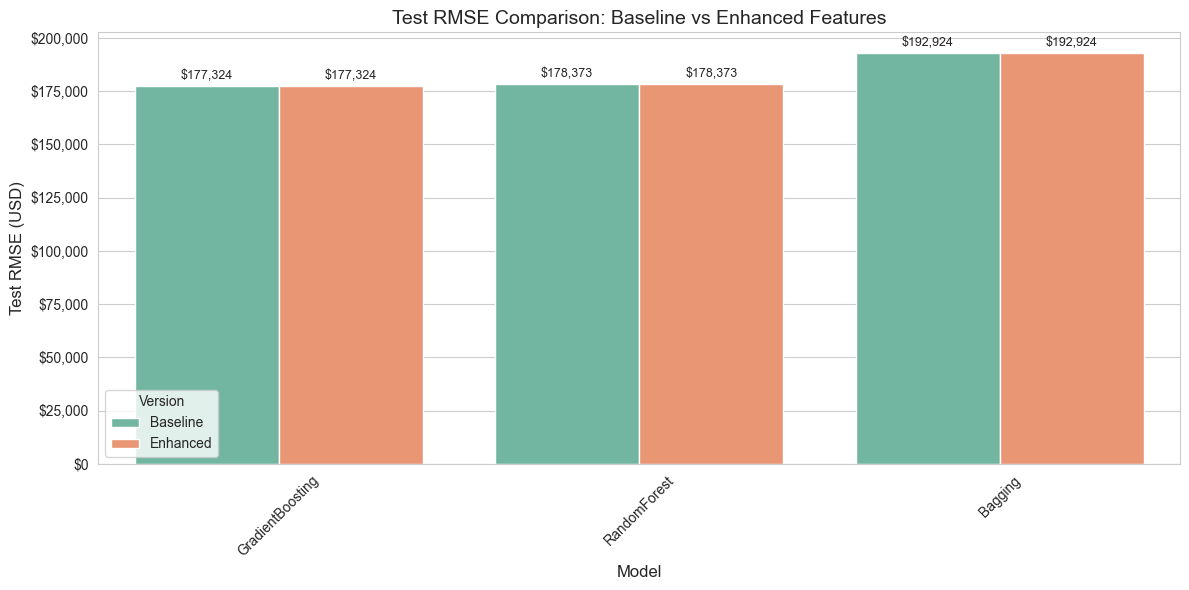

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
# Load baseline and enhanced results
baseline_df = pd.read_csv("Baseline_Model_Comparison.csv", usecols=["Model", "Test RMSE"])
enhanced_df = pd.read_csv("Enhanced_Model_Comparison.csv", usecols=["Model", "Test RMSE"])
# Add version labels
baseline_df["Version"] = "Baseline"
enhanced_df["Version"] = "Enhanced"
# Combine both
combined = pd.concat([baseline_df, enhanced_df], ignore_index=True)
# Sort models by Enhanced performance
model_order = (
    enhanced_df.sort_values("Test RMSE")["Model"].tolist()
)
# Set up plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")
# Plot bar chart
ax = sns.barplot(
    data=combined,
    x="Model",
    y="Test RMSE",
    hue="Version",
    order=model_order,
    palette=palette
)
# Format y-axis as dollars
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', label_type='edge', padding=3, fontsize=9)
# Add title and axis labels
plt.title("Test RMSE Comparison: Baseline vs Enhanced Features", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Test RMSE (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Version")
plt.tight_layout()
plt.show()

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

For each model, we chose to use GridSearchCV to fine tune them. We ran the grid search multiple times until we found the optimal hyperparameter ranges that we used above. 

As per part 3, we found clusters where certain features were performing better in ceratin models. It was notable to note that the 3 models we selected all had very similar features that it found more valuable, such as latitud, og_calculatedfinishedsquarefeet, yearbuilt, and sqft_x_bath.

For our final ranking, we chose the following models from best to worst: Gradient Boosting, Random Forest, Bagging. It appears gradient boosting has the best predictive performance ($17734 RMSE) and can analyze non-linear relationships well, although it does have a very slow training time. Random forest is a close second, only differing in RMSE from Gradient Boosting by $1,000 ($178373 RMSE), showing that it can capture most of the same patterns as Gradient Boosting. Bagging is in 3rd, a significant drop in RMSE from gradient boosting ($192924 RMSE), showing that bootstrapping methods don't do well in capturing complex relationships of house price predictability in this dataset. 

Gradient Boosting: CV RMSE = $175,392 vs. Test RMSE = $177,324 (difference of ~$1,932)
Random Forest: CV RMSE = $177,323 vs. Test RMSE = $178,373 (difference of ~$1,050)
Bagging: CV RMSE = $191,592 vs. Test RMSE = $192,923 (difference of ~$1,331)

We mentioned the possibility of Overfitting earlier in this notebook, but The relatively small and consistent gaps across all models indicate that there are no cases severe overfitting. Random Forest actually shows the smallest gap, suggesting it might be the most resistant to overfitting in this scenario.

However, the consistency of results suggests we're approaching an error floor around 177,000 RMSE, which may represent the inherent unpredictability in housing prices given the available features. Significant improvements would likely require additional data sources or domain-specific feature engineering based on real estate expertise.

In conclusion, the results from this workflow are a little different than what we expected. For milestone 1, we should have focused more on nonlinear features, as from this milestone we've gathered that ensemble models do better in predicting house price predictability.

